# Exploratory Data Analysis
From this point all data is taken from already pre-processed, cleaned datasets.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holoviews as hv
from holoviews import opts, dim
from bokeh.sampledata.les_mis import data
from bokeh.plotting import show



In [11]:
df_art = pd.read_csv('data/cleaned_articles.csv')
df_rep = pd.read_csv('data/cleaned_chosen_representatives.csv')

df_art["title"].value_counts().head(10)

title
Rep. Boebert Leads Congress in Number of Amendments Filed to Spending Bills                                                 12
Rep. Soto Calls for Senate Action on Key House-Passed Bills and Highlights Some Key Bipartisan Achievements for the Year    12
THE TRUMP BUDGET: A BAD DEAL FOR GEORGIA’S SECOND CONGRESSIONAL DISTRICT                                                    10
CONGRESSMAN BISHOP STATEMENT ON 9/11 ANNIVERSARY                                                                            10
CHAIRMAN BISHOP CONDEMNS CONTINUED HOUSE GOP DELAY OF EXPANDED DISASTER APPROPRIATIONS BILL                                 10
CONGRESSMAN BISHOP STATEMENT ON PRESIDENT’S FY18 BUDGET REQUEST                                                              9
CONGRESSMAN BISHOP STATEMENT REGARDING THE STATE OF THE UNION ADDRESS                                                        9
CONGRESSMAN BISHOP SECURES HISTORIC INVESTMENT IN AMERICAN FAMILIES AND COMMUNITIES                      

In [12]:
rep_to_party = dict(zip(df_rep["name"], df_rep["party"]))

title_counts = df_art["title"].value_counts()
representative_counts = df_art["representative_name"].value_counts()

topics_per_article_counts = pd.DataFrame({
    "title": title_counts.index,
    "count": title_counts.values
}).merge(df_art[['title', 'representative_name']].drop_duplicates(), on='title', how='left')

topics_per_article_counts.rename(columns={"representative_name": "representative"}, inplace=True)

topics_per_article_counts["party"] = [rep_to_party[rep] for rep in topics_per_article_counts["representative"]]
topics_per_article_counts.sort_values(by="representative", key=lambda col: representative_counts[col], inplace=True, ascending=False)
topics_per_article_counts["representative"] = topics_per_article_counts["representative"].apply(lambda x: x + f'({representative_counts[x]})')

In [13]:
def describe_axis(ax, title, xlabel, ylabel):
    ax.set_title(title, size=18)
    ax.set_xlabel(xlabel, size=14)
    ax.set_ylabel(ylabel, size=14)

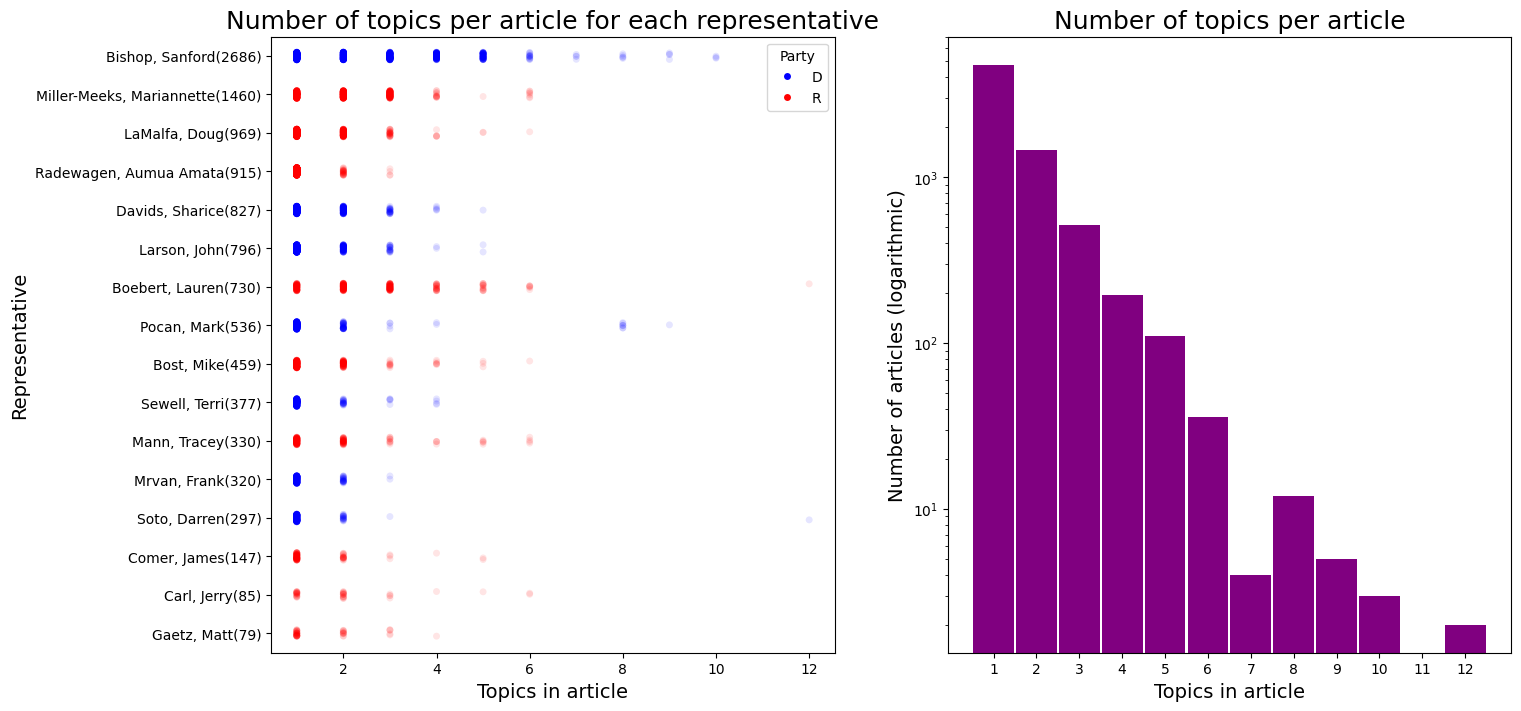

In [14]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(16,8), facecolor="white")

palette = {"D": "blue", "R": "red"}
sns.stripplot(x="count", y="representative", data=topics_per_article_counts, ax=ax[0], jitter=True, alpha=0.1, hue="party", palette=palette)
describe_axis(ax[0], "Number of topics per article for each representative", "Topics in article", "Representative")

# Override alpha for legend
handles, labels = ax[0].get_legend_handles_labels()
for handle in handles:
    handle.set_alpha(1)
ax[0].legend(handles=handles, labels=labels, title="Party")



ax[1].hist(title_counts.values, color="purple", bins = 12, log=True, rwidth=0.95)
describe_axis(ax[1], "Number of topics per article", "Topics in article", "Number of articles (logarithmic)")

#Override x-axis ticks behaviour
bin_edges = ax[1].patches
bin_centers = [patch.get_x() + patch.get_width() / 2 for patch in bin_edges]
ax[1].set_xticks(bin_centers)
ax[1].set_xticklabels(list(range(1, title_counts.max() + 1)));


In [89]:
df_count_r = topics_per_article_counts[topics_per_article_counts['party'] == 'R']
df_count_d = topics_per_article_counts[topics_per_article_counts['party'] == 'D']
title_counts_r = df_count_r["count"].value_counts()[:5]
title_counts_d = df_count_d["count"].value_counts()[:5]

combined_counts = pd.DataFrame({
    'R': title_counts_r,
    'D': title_counts_d
})

combined_counts['R_norm'] = combined_counts['R'] / (combined_counts['R'] + combined_counts['D'])
combined_counts['D_norm'] = combined_counts['D'] / (combined_counts['R'] + combined_counts['D'])
combined_counts 


,R,D,R_norm,D_norm
count,,,,
1,2237,2535,0.468776,0.531224
2,813,650,0.555707,0.444293
3,274,242,0.531008,0.468992
4,53,142,0.271795,0.728205
5,28,82,0.254545,0.745455


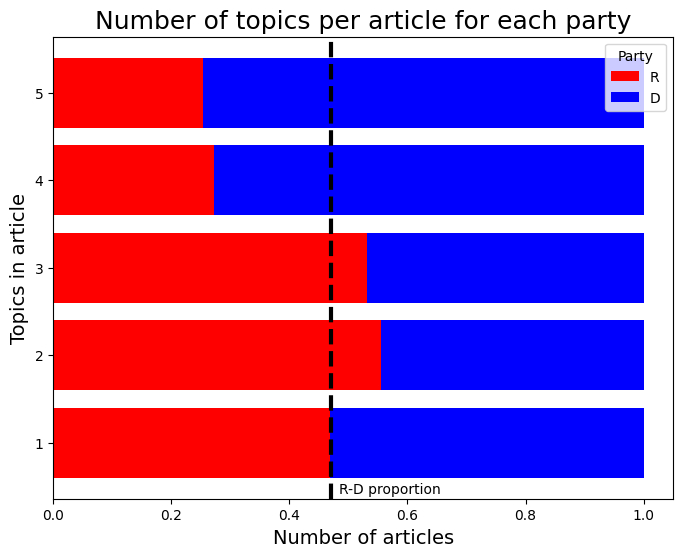

In [110]:
fig, ax = plt.subplots(figsize=(8, 6))

bars_r = ax.barh(combined_counts.index, combined_counts['R_norm'], color='red', label='R')
bars_d = ax.barh(combined_counts.index, combined_counts['D_norm'], left=combined_counts['R_norm'], color='blue', label='D')

describe_axis(ax, "Number of topics per article for each party", "Number of articles", "Topics in article")
ax.legend(title='Party')

proportion = len(df_art[df_art["representative_party"] == 'R']) / len(df_art["representative_party"])
ax.axvline(x=proportion, color='black', linestyle='--', linewidth=3)
ax.text(y=0.42, x=proportion + 0.1, s='R-D proportion', color='black', fontsize=10, ha='center')

plt.show()

In [63]:
#Data preparation for chord chart below
grouped = df_art.groupby(['title', 'date'])['issue'].apply(list).reset_index()

topics = df_art['issue'].unique()
co_occurrence_matrix = pd.DataFrame(0, index=topics, columns=topics)

for topics_list in grouped['issue']:
    for i in range(len(topics_list)):
        for j in range(i+1, len(topics_list)):
            co_occurrence_matrix.loc[topics_list[i], topics_list[j]] += 1
            if i != j:
                co_occurrence_matrix.loc[topics_list[j], topics_list[i]] += 1

mask_upper = np.triu(np.ones(co_occurrence_matrix.shape), k=1).astype(bool)
co_occurrence_matrix.where(~mask_upper, 0, inplace=True)

co_occurrence_matrix.reset_index(inplace=True)
co_occurrence_matrix.drop(columns='index', inplace=True)
co_occurrence_matrix.columns = list(range(len(co_occurrence_matrix.columns)))

co_occurrence_matrix = co_occurrence_matrix.stack().reset_index()
co_occurrence_matrix.columns = ['source', 'target', 'value']

     source  target  value
0         0       0      0
1         0       1      0
2         0       2      0
3         0       3      0
4         0       4      0
..      ...     ...    ...
284      16      12     10
285      16      13      1
286      16      14      0
287      16      15      0
288      16      16      0

[289 rows x 3 columns]


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
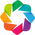

In [64]:
hv.extension('bokeh')
hv.output(size=300)

chord_nodes = hv.Dataset(pd.DataFrame({"name": topics}), "index")

chord = hv.Chord((co_occurrence_matrix, chord_nodes)).select(value=(5, None))
chord.opts(
    opts.Chord(cmap='Category20', edge_cmap='Category20', edge_color=dim('source').str(), 
            labels='name', node_color=dim('index').str()))
show(hv.render(chord))

[0, 1, 2]